In [1]:
import pandas as pd

In [6]:
file_path = "/home/so87pot/n0w0f/structllm/src/structllm/models/clustered_results_1000.csv"

data = pd.read_csv(file_path,sep='\t')

In [7]:
data

,slices,formula,crystal,cluster
0,Y Y 0 1 - o -,Y2,hexagonal,0
1,B B N N 0 3 o o o 1 2 o o o,B2N2,hexagonal,3
2,Au Au Au Au S S 0 4 o o o 0 5 o o o 1 5 o o o ...,Au4S2,cubic,4
3,Mn Mn Mn Mn S S S S 0 5 - o o 0 6 o - o 0 7 o ...,Mn4S4,cubic,1
4,Mn Mn Mn Mn S S S S 0 5 - o o 0 6 o - o 0 7 o ...,Mn4S4,cubic,1
...,...,...,...,...
4994,Li Al Al P 0 3 o o o 1 2 o o o,Al2LiP,cubic,2
4995,Sn Sn Sn Sn S S S S 0 1 o o o 0 6 o o o 1 6 o ...,S4Sn4,orthorhombic,2
4996,He He 0 1 - - - 0 1 - - o 0 1 - o o 0 1 o - - ...,He2,hexagonal,2
4997,Cd Cd Se Se 0 3 o o o 0 2 o o + 1 2 o o o 1 3 ...,Cd2Se2,hexagonal,4


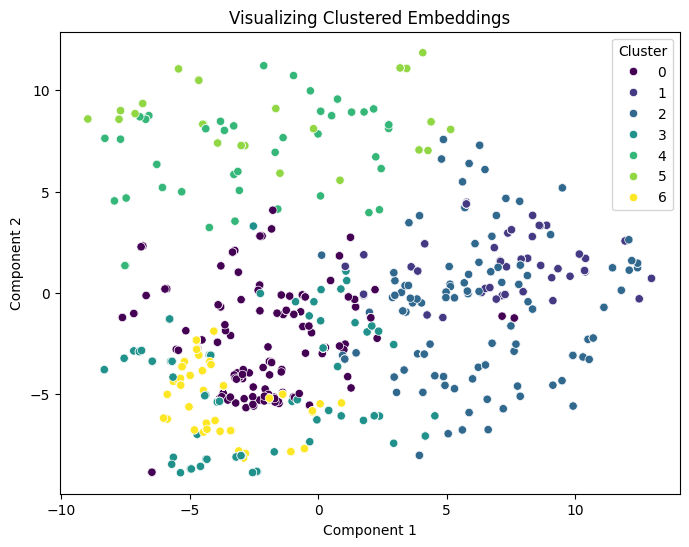

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file containing embeddings and cluster labels
csv_file = "clustered_embeddings_396_5000.csv"  # Replace with your CSV file path
data = pd.read_csv(csv_file, sep='\t')

# Separate embeddings and cluster labels
embeddings = data.iloc[:, :-1].values  # Assuming the embeddings are in the first columns
cluster_labels = data['cluster'].values

# Reduce dimensionality of embeddings for visualization (e.g., using PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create DataFrame with reduced embeddings and cluster labels
df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
df['Cluster'] = cluster_labels

# Plot clustered embeddings
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Cluster', palette='viridis')
plt.title('Visualizing Clustered Embeddings')
plt.legend(title='Cluster')

# Save the plot as a PNG file
output_png = "clustered_embeddings_plot_396k.png"  # Set the desired output file name
plt.savefig(output_png)

# Display the plot
plt.show()


In [15]:
from transformers import AutoTokenizer, AutoModel, PreTrainedTokenizerFast
import torch
from tokenizers import Tokenizer


tokenizer_ = Tokenizer.from_file("/home/so87pot/n0w0f/structllm/src/structllm/tokenizer/tokenizer-slice_130k.json")
tokenizer = PreTrainedTokenizerFast(
            tokenizer_object=tokenizer_,
            unk_token="[UNK]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            sep_token="[SEP]",
            mask_token="[MASK]",
        )
model = AutoModel.from_pretrained("/home/so87pot/n0w0f/structllm/src/structllm/models/pretrain/checkpoints/27k_new/checkpoint-2000")


Some weights of BertModel were not initialized from the model checkpoint at /home/so87pot/n0w0f/structllm/src/structllm/models/pretrain/checkpoints/27k_new/checkpoint-2000 and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
model_output[0].shape

torch.Size([2, 68, 512])

In [21]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
slice = ['In In In In P P P P 0 3 - - o 0 2 - o - 0 1 o - - 1 2 - + o 1 3 - o + 2 3 o - + 4 5 o o o 4 6 o o o 4 7 o o o 5 7 o o o 5 6 o o o 6 7 o o o',
        'Cu Cu Cu Cu 0 3 - - o 0 2 - o - 0 1 o - - 1 2 - + o 1 3 - o + 2 3 o - + ']

# Tokenize sentences
encoded_input = tokenizer(slice, padding=True, truncation=True, return_tensors='pt', max_length = 128)

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)



In [37]:
encoded_input['input_ids'][0].shape

torch.Size([68])

In [29]:
# Perform pooling. In this case, mean pooling.
slice_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(slice_embeddings)

Sentence embeddings:
tensor([[-0.1865, -0.1048, -0.4708,  ..., -0.7264,  0.2279, -0.3337],
        [-0.3447,  0.0786, -0.3203,  ..., -0.5192,  0.0436,  0.2221]])


In [30]:
slice_embeddings.shape

torch.Size([2, 512])

In [51]:
slice_embeddings.sum()

tensor(-0.1049)

In [47]:
model_output[0].shape

torch.Size([2, 68, 512])

In [48]:
model_output.last_hidden_state.shape

torch.Size([2, 68, 512])

In [41]:
mm = model_output.last_hidden_state[:, 0, :]

In [50]:
mm.sum()

tensor(-0.0808)